In [10]:
import os
import cv2
import numpy as np
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.png")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        image = image.transpose((2, 0, 1)) / 255.0  # CHW
        mask = mask[np.newaxis, ...] / 255.0       # CHW

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask


In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [15]:
def visualize_predictions(model_path, image_dir, mask_dir, num_samples=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load model
    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Dataset and dataloader
    dataset = SegmentationDataset(image_dir, mask_dir)
    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred_mask = pred.squeeze().cpu().numpy()

        image_np = image.permute(1, 2, 0).numpy()
        gt_mask = mask.squeeze().numpy()

        # Plot
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask > 0.5, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [21]:
from sklearn.metrics import accuracy_score

def train_with_validation():
    # Paths
    image_dir = r"D:\FYDP\image\"
    mask_dir = r"D:\FYDP\image\"

    # Hyperparameters
    batch_size = 4
    lr = 1e-4
    epochs = 100
    val_split = 0.2
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Dataset & Split
    full_dataset = SegmentationDataset(image_dir, mask_dir)
    total_size = len(full_dataset)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Model
    model = UNet().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

                preds = (outputs > 0.5).float()
                targets = (masks > 0.5).float()

                all_preds.extend(preds.cpu().numpy().flatten())
                all_targets.extend(targets.cpu().numpy().flatten())


        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_acc = accuracy_score(all_targets, all_preds)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), "unet_model.pth")
    print("Model saved as unet_model.pth")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Accuracy", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/100 | Train Loss: 0.2930 | Val Loss: 0.2548 | Val Acc: 0.9128
Epoch 2/100 | Train Loss: 0.2489 | Val Loss: 0.2401 | Val Acc: 0.9128
Epoch 3/100 | Train Loss: 0.2457 | Val Loss: 0.2496 | Val Acc: 0.9128
Epoch 4/100 | Train Loss: 0.2388 | Val Loss: 0.2299 | Val Acc: 0.9128
Epoch 5/100 | Train Loss: 0.2282 | Val Loss: 0.2422 | Val Acc: 0.9128
Epoch 6/100 | Train Loss: 0.2151 | Val Loss: 0.2068 | Val Acc: 0.9128
Epoch 7/100 | Train Loss: 0.2056 | Val Loss: 0.1986 | Val Acc: 0.9179
Epoch 8/100 | Train Loss: 0.1999 | Val Loss: 0.2005 | Val Acc: 0.9179
Epoch 9/100 | Train Loss: 0.1994 | Val Loss: 0.1998 | Val Acc: 0.9196
Epoch 10/100 | Train Loss: 0.2012 | Val Loss: 0.1944 | Val Acc: 0.9192
Epoch 11/100 | Train Loss: 0.1989 | Val Loss: 0.1915 | Val Acc: 0.9220
Epoch 12/100 | Train Loss: 0.1935 | Val Loss: 0.1965 | Val Acc: 0.9240
Epoch 13/100 | Train Loss: 0.1924 | Val Loss: 0.1864 | Val Acc: 0.9235
Epoch 14/100 | Train Loss: 0.1881 | Val Loss: 0.1895 | Val Acc: 0.9224
Epoch 15/100 | 

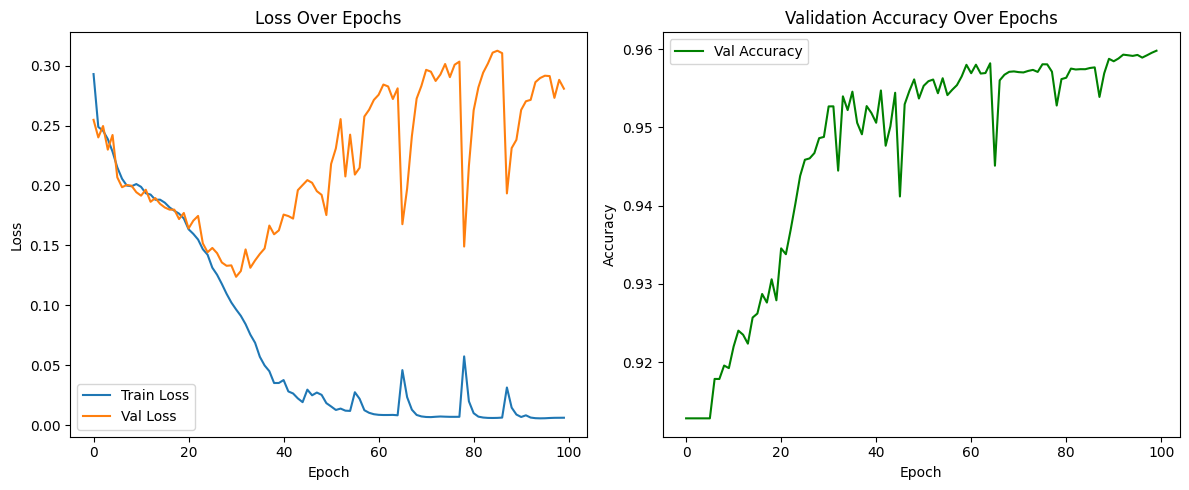

In [22]:
train_with_validation()
